In [18]:
from deepuq.analyze.analyze import AggregateCheckpoints
from deepuq.models.models import model_setup_DER, model_setup_DE
from deepuq.data.data import DataPreparation
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import pandas as pd
import seaborn as sns

In [19]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoints = AggregateCheckpoints()

In [20]:
uniform = True
norm = False
verbose = False
epoch = 99
out_dir = '../DeepUQResources/'

In [21]:
experiments_df = {
    "DE, 0D, input, low": {
        "model": "DE",
        "size_df": 1000,
        "noise": "low",
        "dim": "0D",
        "injection": "input"
    },
    "DE, 0D, input, medium": {
        "model": "DE",
        "size_df": 1000,
        "noise": "medium",
        "dim": "0D",
        "injection": "input"
    },
    "DE, 0D, input, high": {
        "model": "DE",
        "size_df": 1000,
        "noise": "high",
        "dim": "0D",
        "injection": "input"
    },
    "DE, 0D, output, low": {
        "model": "DE",
        "size_df": 1000,
        "noise": "low",
        "dim": "0D",
        "injection": "output"
    },
    "DE, 0D, output, medium": {
        "model": "DE",
        "size_df": 1000,
        "noise": "medium",
        "dim": "0D",
        "injection": "output"
    },
    "DE, 0D, output, high": {
        "model": "DE",
        "size_df": 1000,
        "noise": "high",
        "dim": "0D",
        "injection": "output"
    },
    "DE, 2D, input, low": {
        "model": "DE",
        "size_df": 5000,
        "noise": "low",
        "dim": "2D",
        "injection": "input"
    },
    "DE, 2D, input, medium": {
        "model": "DE",
        "size_df": 5000,
        "noise": "medium",
        "dim": "2D",
        "injection": "input"
    },
    "DE, 2D, input, high": {
        "model": "DE",
        "size_df": 5000,
        "noise": "high",
        "dim": "2D",
        "injection": "input"
    },
    "DE, 2D, output, low": {
        "model": "DE",
        "size_df": 5000,
        "noise": "low",
        "dim": "2D",
        "injection": "output"
    },
    "DE, 2D, output, medium": {
        "model": "DE",
        "size_df": 5000,
        "noise": "medium",
        "dim": "2D",
        "injection": "output"
    },
    "DE, 2D, output, high": {
        "model": "DE",
        "size_df": 5000,
        "noise": "high",
        "dim": "2D",
        "injection": "output"
    },
}

In [22]:
n_models = 15

inject_type_list = ["output", "input"]
data_dim_list = ["0D", "2D"]
model_type = ["DE", "DER"]
noise_list = ["low", "medium", "high"]

mega_dict = {}

# Nested loops to fill the dictionary
for noise in noise_list:
    mega_dict[noise] = {}  # Create a sub-dictionary for each noise level
    for model in model_type:
        mega_dict[noise][model] = {}  # Create a sub-dictionary for each model type
        for dim in data_dim_list:
            mega_dict[noise][model][dim] = {}  # Create a sub-dictionary for each data dimension
            for inject_type in inject_type_list:
                mega_dict[noise][model][dim][inject_type] = []


In [ ]:
for experiment_name, params in experiments_df.items():
    print(f"Experiment: {experiment_name}")
    for key, value in params.items():
        print(f"  {key}: {value}")
        chk = 0
        data = DataPreparation()
        x_test, y_test = data.generate_df(
                    params["size_df"], params["noise"],
                    params["dim"], params["injection"], uniform, verbose,
                    rs_prior=42, rs_simulate_0D=41, rs_simulate_2D=41, rs_uniform=40)
        
        if params["model"] == "DER":
            setupmodel, lossFn = model_setup_DER(
                params["model"], DEVICE, n_hidden=64, data_type=params["dim"])
            COEFF = 0.01
            chk = checkpoints.load_checkpoint(
                params["model"],
                params["injection"],
                params["dim"],
                params["noise"],
                epoch,
                DEVICE,
                path="../DeepUQResources/checkpoints/",
                COEFF=COEFF
            )
            setupmodel.load_state_dict(chk.get("model_state_dict"))
            setupmodel.eval()
            y_pred = setupmodel(torch.Tensor(x_test)).detach().numpy()
            beta = y_pred[:, 3]
            nu = y_pred[:, 1]
            alpha = y_pred[:, 2]
            u_al = np.sqrt(abs(beta * (1 + nu) / (alpha * nu)))     
        elif params["model"] == "DE":
            models_used = 0
            loss = "bnll_loss"
            setupmodel, lossFn = model_setup_DE(
                loss, DEVICE, n_hidden=64, data_type=params["dim"])
            BETA = 0.5
            u_al = []
            for m in range(n_models):
                if models_used > 9:
                    break
                chk = checkpoints.load_checkpoint(
                    params["model"],
                    params["injection"],
                    params["dim"],
                    params["noise"],
                    epoch,
                    DEVICE,
                    path="../DeepUQResources/checkpoints/",
                    BETA=BETA,
                    nmodel=m
                )
                try:
                    setupmodel.load_state_dict(chk.get("model_state_dict"))
                except RuntimeError:
                    print(chk)
                setupmodel.eval()
                y_pred = setupmodel(torch.Tensor(x_test)).detach().numpy()
                # for some reason if the model fails it predicts
                # really large values for sigma
                
                if np.all(y_pred[:, 1] == y_pred[0, 1]) or np.mean(np.sqrt(y_pred[:, 1])) > 0.2:
                    # All values are the same
                    print("All values in y_pred[:,1] are the same or they are really high")
                    # then we need to skip this model
                    print('not using this model ', m)
                    continue
                else:
                    '''
                    plt.clf()
                    plt.hist(np.sqrt(y_pred[:, 1]), bins=100)
                    plt.title(f'model m {m}')
                    plt.show()
                    '''
                    print('using this model', m)
                    models_used += 1
                    #print('using this model ', m)            
                u_al_one = np.sqrt(y_pred[:, 1])
                u_al.append(u_al_one)

                
        # populate the mega dict
        mega_dict[params["noise"]][params["model"]][params["dim"]][params["injection"]] = u_al

Experiment: DE, 0D, input, low
  model: DE
number of sims 5000
YES WERE VARYING SIGMA
0D data generated,                 with noise injected type: input.
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_0D_noise_low_beta_0.5_nmodel_0_epoch_99.pt
using this model 0
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_0D_noise_low_beta_0.5_nmodel_1_epoch_99.pt
using this model 1
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_0D_noise_low_beta_0.5_nmodel_2_epoch_99.pt
using this model 2
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_0D_noise_low_beta_0.5_nmodel_3_epoch_99.pt
using this model 3
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_0D_noise_low_beta_0.5_nmodel_4_epoch_99.pt
using this model 4
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_0D_noise_low_beta_0.5_nmodel_5_epoch_99.pt
using this model 5
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_0D_noise_low_beta_0.5_nmodel_6_epoch_99.pt
using this 

/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-neurips-ws-2024-TMQ0mHE3-py3.10/lib/python3.10/site-packages/deepuq/data/data.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df[key] = torch.tensor(value)


using this model 4
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_0D_noise_low_beta_0.5_nmodel_5_epoch_99.pt
using this model 5
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_0D_noise_low_beta_0.5_nmodel_6_epoch_99.pt
using this model 6
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_0D_noise_low_beta_0.5_nmodel_7_epoch_99.pt
using this model 7
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_0D_noise_low_beta_0.5_nmodel_8_epoch_99.pt
using this model 8
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_0D_noise_low_beta_0.5_nmodel_9_epoch_99.pt
using this model 9
  dim: 0D
number of sims 5000
YES WERE VARYING SIGMA
0D data generated,                 with noise injected type: input.
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_0D_noise_low_beta_0.5_nmodel_0_epoch_99.pt
using this model 0
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_0D_noise_low_beta_0.5_nmodel_1_epoch_99.pt
using this model 1
DE
loa

In [ ]:
print('mega dict', mega_dict)

ValueError: `dataset` input should have multiple elements.

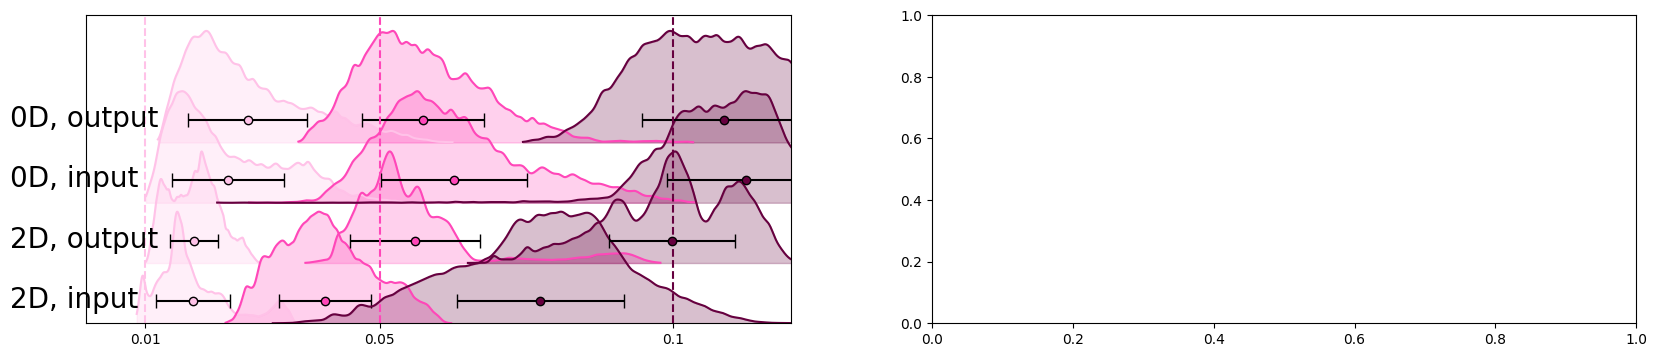

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from scipy.stats import gaussian_kde

# suppress seaborn/pandas specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Example setup, use your actual data/model outputs
noise_list = ["low", "medium", "high"]
model_type = ["DE", "DER"]
inject_type_list = ["output", "input"]
data_dim_list = ["0D", "2D"]

# Set up figure and axes
fig, axes = plt.subplots(1, len(model_type), figsize=(20, 4))
axes = axes.flatten()
index = 0

sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}
color_noise = ['#FFC2E8', '#FF47B9', '#66003F']#'#B80071']
#color_noise = ['#C5C0EC', '#6F62D0', '#3C2F9D']

# Define x-axis limits for each noise level
x_limits = {
    "low": (0, 0.05),
    "medium": (0, 0.1),
    "high": (0, 0.12)
}


for m, model in enumerate(model_type):
    ax = axes[index]
    for n, noise in enumerate(noise_list):
        
        y_offset = 0  # Initialize a consistent y_offset
        kde_max = 0  # Track the maximum y-value across all KDE plots
        
        # Collect KDE data to plot
        kde_data = []
        color_twerk = 0
        for j, dim in enumerate(data_dim_list):
            for i, inject_type in enumerate(inject_type_list):
                # Generate or load aleatoric uncertainty data (replace with your own logic)
                u_al_data = mega_dict[noise][model][dim][inject_type]
                
                
                # Stack the DEs
                if model == "DE":
                    combined_array = np.concatenate(u_al_data)
                elif model == "DER":
                    combined_array = u_al_data
                
                # Store KDE data
                kde_data.append((combined_array, f"{dim}, {inject_type}"))
                
        
        # Plot KDEs in reverse order
        for combined_array, label in reversed(kde_data):
            '''
            kde = sns.kdeplot(combined_array, fill=True, bw_adjust=0.5, alpha=0.75, ax=ax,
                              clip_on=False, color=color, label=label)

            # Retrieve the KDE data
            x = kde.lines[0].get_data()[0]
            y = kde.lines[0].get_data()[1]
            
            # Normalize the KDE data
            max_height = 0.5  # Desired maximum height
            y_normalized = (y / y.max()) * max_height
            
            # Clear the previous KDE plot
            ax.clear()
            
            # Plot the normalized KDE
            ax.fill_between(x, y_normalized, color='blue', alpha=0.75)
            ax.plot(x, y_normalized, color='blue', label='Normalized KDE')
            '''
            # Compute KDE
            kde = gaussian_kde(combined_array, bw_method=0.05)  # Adjust bw_method as needed
            
            # Define range of x values
            x = np.linspace(min(combined_array), max(combined_array), 1000)
            
            # Evaluate KDE over x values
            y = kde(x)
            
            # Normalize the KDE data
            max_height = 0.5  # Desired maximum height
            y_normalized = (y / y.max()) * max_height
            
            # Plot the normalized KDE
            ax.fill_between(x, y_offset, y_normalized + y_offset, color=color_noise[n], alpha=0.25)
            ax.plot(x, y_normalized + y_offset, color=color_noise[n], label=label)
            if n == 0 and m == 0:
                #transform = ax.get_xaxis_trasform()
                #ann = ax.annotate(label, xy=(-0.07, y_offset+0.07), xycoords=transform, size=20)
                ax.annotate(label, xy=(-0.013, y_offset+0.07), size=20, annotation_clip=False)
            ax.scatter(
                np.mean(combined_array), y_offset + 0.1,
                color=color_noise[n], edgecolor='black', zorder=100)
            ax.errorbar(
                np.mean(combined_array), y_offset + 0.1,
                xerr = np.std(combined_array),
                color='black', capsize=5)
            #y_offset += 0.25
            y_offset += 0.27

        # Set title and limits
        #ax.set_title(f'{model} - {noise} noise')
        ax.set_yticks([])  # Hide y-ticks
        #ax.set_ylim(0, y_offset+0.25)  # Adjust y-limits based on the max y_offset
        ax.set_ylim(0, y_offset+0.3)
        
        # Set x-axis limits after plotting
        ax.set_xlim(x_limits[noise])

        # Add vertical line indicating sigma_y for reference
        if noise == "low":
            ax.axvline(x=0.01, color=color_noise[n], ls='--')
        elif noise == "medium":
            ax.axvline(x=0.05, color=color_noise[n], ls='--')
        elif noise == "high":
            ax.axvline(x=0.10, color=color_noise[n], ls='--')
        '''
        # Only add the legend on the first subplot
        if index == 0:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles[::-1], labels[::-1], loc='upper right')  # Reverse the order of the legend
        else:
        '''
        ax.set_xticks([0.01, 0.05, 0.1])
        ax.set_xticklabels([0.01, 0.05, 0.10])
        ax.legend().remove()  # Remove the legend from all other subplots
        ax.set_yticklabels([])
    index += 1

axes[0].set_xlim([0.005, 0.11])
axes[1].set_xlim([0.005, 0.11])

axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)
axes[0].set_title('Deep Ensemble (DE)', size=20)
axes[1].set_title('Deep Evidential Regression (DER)', size=20)

#axes[0].set_xlabel(r'$\sigma_{al}$')
#plt.subplots_adjust(wspace=0)
fig.supxlabel(r'Predicted Aleatoric Uncertainty, $\sigma_{al}$', size=20, y=0.05)

# Adjust layout and save the plot
plt.tight_layout()
plt.show()

#plt.savefig(
#    f'../../../Desktop/sigma_in_sigma_out_ridgeplot_ensemble_two_panel_noise_color_{n_models}_uniform.png',
#    dpi=1000,
#    bbox_inches='tight')